<a href="https://colab.research.google.com/github/aleschiavo94/Convolutional-Neural-Network-for-Medical-Imaging-Analysis---Abnormality-detection-in-mammography/blob/main/PreTrained_CNN_benign_vs_malign_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Project Setup


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
#ROC-AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.wrappers.scikit_learn import KerasClassifier

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
PLOTS_PATH =  os.path.join(base_path, 'plots/Benign-Malign')
train_img_path = os.path.join(base_path, 'numpy data/train_tensor.npy')
train_label_path = os.path.join(base_path, 'numpy data/train_labels.npy')
test_img_path = os.path.join(base_path, 'numpy data/public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'numpy data/public_test_labels.npy')

MODEL_PATH = os.path.join(base_path, "models/Benign-Malign")

# to produce final model report histogram 
AUC_values_1x = []
AUC_values_3x = []
AUC_values_5x = []
TPR_values = []
FPR_values = []
ACC_values_1x = []
ACC_values_3x = []
ACC_values_5x = []

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


##1.1 Utility Functions

In [ ]:
# ----------------------- Utility Functions -----------------------
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.7*len(dataset))]
  valid_data_split = dataset[int(0.7*len(dataset)):]
  train_labels_split = labels[:int(0.7*len(labels))]
  valid_labels_split = labels[int(0.7*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify benign and malign cases 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # malign
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    #Precision = TP/(TP+FP)
      #Precision answers the following: How many of those who we labeled as diabetic are actually diabetic?
    precision = TP / (TP + FP)

    #Recall/Sensitivity/TPR = TP/(TP+FN)
        #Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
    tpr = TP / (TP + FN)

    #Specificity = TN/(TN+FP)
        #Specifity answers the following question: Of all the people who are healthy, how many of those did we correctly predict?
    specificity = TN / (TN + FP)

    #FPR  = 1 - Specificity =  FP/FP+TN
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity

Done


##1.2 Visualization Functions

In [ ]:
# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt


def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt
print("Done")

Done


#2 Data Preparation


In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)

train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)

Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


##2.1 Data Visualization

In [ ]:
from PIL import Image
from matplotlib.pyplot import figure, imshow, axis

def display_samples(abnormality_type):
  idx = 0
  counter = 0

  fig = figure(figsize=(20,4))
  while counter < 5:
    #benign masses 
    if test_labels[idx] == abnormality_type:
      img = test_images[idx]
      pil_img = tf.keras.preprocessing.image.array_to_img(img)
      a=fig.add_subplot(1, 5, counter+1)
      imshow(pil_img,cmap='Greys_r')
      axis('off')

      counter += 1
    idx += 1

Benign Masses[first row] VS Malign Masses[second row]


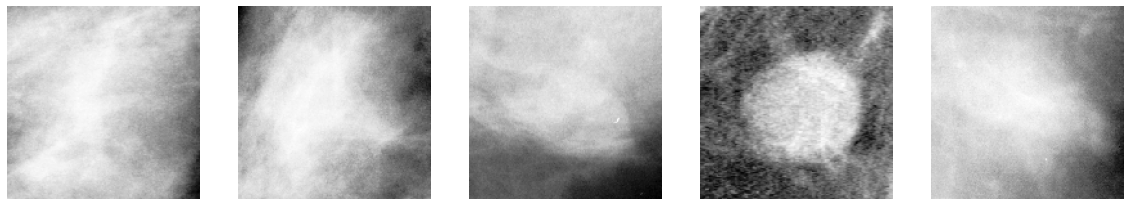

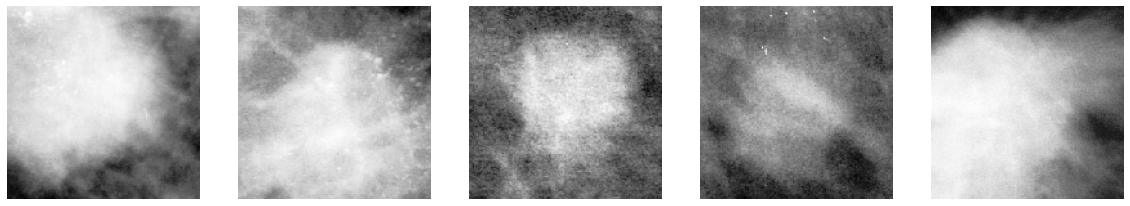

In [ ]:
#benign masses 
print("Benign Masses[first row] VS Malign Masses[second row]")
display_samples(1)

#benign calcifications
display_samples(2)

Benign Calcifications[first row] VS Malign Calcifications[second row]


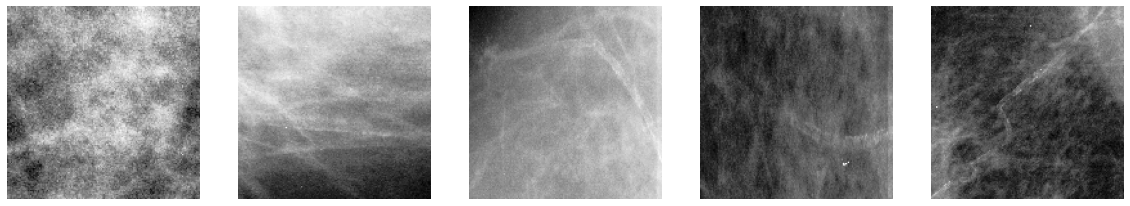

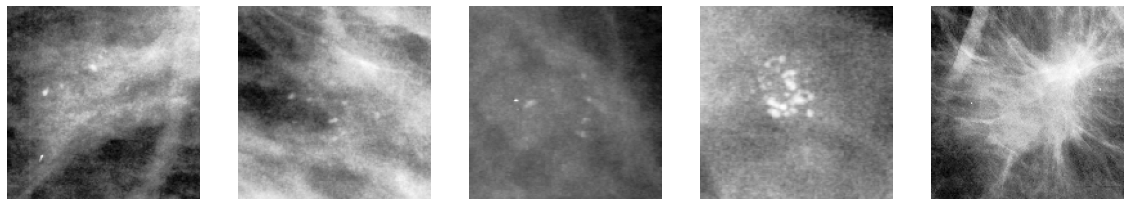

In [ ]:
print("Benign Calcifications[first row] VS Malign Calcifications[second row]")
display_samples(3)

display_samples(4)

##2.2 Data Preprocessing

In [ ]:
#1: Mass, benign
#2: Mass, malignant
#3: Calcification, benign
#4: Calcification, malignant

#count #of masses and #of calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)

print("Benign Masses samples: \t", counts[0])
print("Malign Masses samples: \t", counts[1])
print("Benign Calc samples: \t", counts[2])
print("Malign Calc samples: \t", counts[3])

Benign Masses samples: 	 620
Malign Masses samples: 	 598
Benign Calc samples: 	 948
Malign Calc samples: 	 510


In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])
print()

#train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
#test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

Benign samples:  1568
Malign samples:  1108

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)                                  

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)


##2.3 Global Contrast Normalization

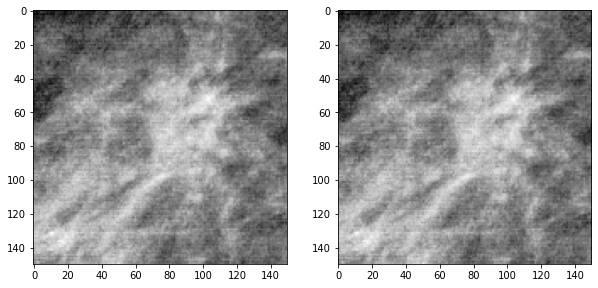

In [ ]:
#Global Contrast Normalization 
import numpy
import scipy
import scipy.misc
from PIL import Image

def global_contrast_normalization(X):
    X_average = numpy.mean(X)
    #print('Mean: ', X_average)
    X = X - X_average
    return X

#nomalize image
norm_image = global_contrast_normalization(train_images[200])

original_image = tf.keras.preprocessing.image.array_to_img(train_images[200])
norm_image = tf.keras.preprocessing.image.array_to_img(norm_image)

#display images 
fig = figure(figsize=(10,5))
a=fig.add_subplot(1, 2, 1)
imshow(original_image,cmap='Greys_r')
a=fig.add_subplot(1, 2, 2)
imshow(norm_image,cmap='Greys_r')

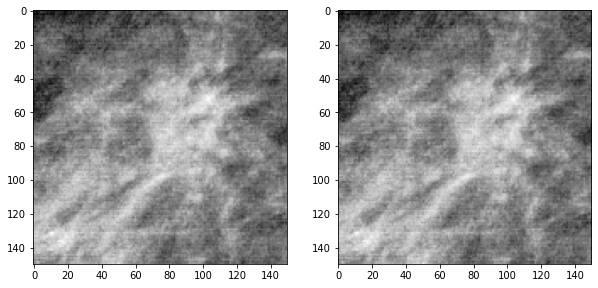

In [ ]:
import numpy
import scipy
import scipy.misc
from PIL import Image


def global_contrast_normalization(X, s, lmda, epsilon):

    # replacement for the loop
    X_average = numpy.mean(X)
    #print('Mean: ', X_average)
    X = X - X_average

    # `su` is here the mean, instead of the sum
    contrast = numpy.sqrt(lmda + numpy.mean(X**2))

    X = s * X / max(contrast, epsilon)
    return X


#nomalize image
norm_image = global_contrast_normalization(train_images[200], 1, 10, 0.000000001)

original_image = tf.keras.preprocessing.image.array_to_img(train_images[200])
norm_image = tf.keras.preprocessing.image.array_to_img(norm_image)

#display images 
fig = figure(figsize=(10,5))
a=fig.add_subplot(1, 2, 1)
imshow(original_image,cmap='Greys_r')
a=fig.add_subplot(1, 2, 2)
imshow(norm_image,cmap='Greys_r')

##2.4 Data Augmentation

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=20,
    zoom_range=(0.5,1.5),
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


##2.5 All-in-one Data Preparation Function

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all-in-one data loading & preprocessing function 
def init_data(base_NN, GCN=True, augmentation=True):
  # Get images and labels (test, train)
  train_images, train_labels, test_images, test_labels = load_training()

  # Get abnormalities only 
  train_images = remove_baseline(train_images)
  train_labels = remove_baseline(train_labels)
  test_images = remove_baseline(test_images)
  test_labels = remove_baseline(test_labels)

  # Suffle index (Previous dataset is ordered)
  train_images, train_labels = shuffle_dataset(train_images, train_labels)

  #print("Train shape: ", train_images.shape)
  #print("Test shape: ", test_images.shape)

  #1: Mass, benign
  #2: Mass, malignant
  #3: Calcification, benign
  #4: Calcification, malignant

  #count #of masses and #of calcifications
  #unique, counts = np.unique(train_labels, return_counts=True)
  #print(unique, counts)

  #print("Benign Masses samples: \t", counts[0])
  #print("Malign Masses samples: \t", counts[1])
  #print("Benign Calc samples: \t", counts[2])
  #print("Malign Calc samples: \t", counts[3])

  #labels remapping
  train_labels = labels_mapping(train_labels)
  test_labels = labels_mapping(test_labels)

  #tensors reshaping for models training 
  train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
  test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
  #print(train_images.shape)
  #print(test_images.shape)

  # split dataset into training and validation set 70-30
  train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

  # All images will be rescaled by 1./65535
  if  base_NN == "VGG16":
    from tensorflow.keras.applications.vgg16 import preprocess_input
  if base_NN == "ResNet50":
    from tensorflow.keras.applications.resnet import preprocess_input
  #if Inception no preprocess function 
  if base_NN == "InceptionV3":
    train_datagen = ImageDataGenerator(rescale=1./65535)
    valid_datagen = ImageDataGenerator(rescale=1./65535)
    test_datagen = ImageDataGenerator(rescale=1./65535) 

  if "InceptionV3" not in base_NN:
    train_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
    valid_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input)
    test_datagen = ImageDataGenerator(rescale=1./65535, preprocessing_function=preprocess_input) 

  if GCN:
    train_images_split_gcn = np.zeros(train_images_split.shape)  
    train_labels_split_gcn = np.zeros(train_labels_split.shape)
    valid_images_split_gcn = np.zeros(valid_images_split.shape)
    valid_labels_split_gcn = np.zeros(valid_labels_split.shape)
    train_datagen = ImageDataGenerator()
    valid_datagen = ImageDataGenerator()
    #global contrast normalization 
    counter = 0
    for image, label in train_datagen.flow(train_images_split, train_labels_split, batch_size=1, shuffle=False):
      #nomalize image
      norm_image = global_contrast_normalization(image, 1, 10, 0.000000001)
      train_images_split_gcn[counter] = norm_image
      train_labels_split_gcn[counter] = label
      
      counter += 1
      if counter == len(train_images_split):
        break
    
    counter = 0
    for image, label in valid_datagen.flow(valid_images_split, valid_labels_split, batch_size=1, shuffle=False):
      #nomalize image
      norm_image = global_contrast_normalization(image, 1, 10, 0.000000001)
      valid_images_split_gcn[counter] = norm_image
      valid_labels_split_gcn[counter] = label
      
      counter += 1
      if counter == len(valid_images_split):
        break
    if base_NN == "InceptionV3":  
      train_datagen = ImageDataGenerator(rescale=1./np.max(train_images_split_gcn))
      valid_datagen = ImageDataGenerator(rescale=1./np.max(valid_images_split_gcn))     
    else:
      train_datagen = ImageDataGenerator(rescale=1./np.max(train_images_split_gcn), preprocessing_function=preprocess_input)
      valid_datagen = ImageDataGenerator(rescale=1./np.max(valid_images_split_gcn), preprocessing_function=preprocess_input)      

  if GCN and augmentation:
    if base_NN == "InceptionV3":
      train_datagen = ImageDataGenerator(
          rescale=1./np.max(train_images_split_gcn),
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')
    else:
      train_datagen = ImageDataGenerator(
          rescale=1./np.max(train_images_split_gcn),
          preprocessing_function=preprocess_input,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')

  if not GCN and augmentation:
    if base_NN == "InceptionV3":
      train_datagen = ImageDataGenerator(
          rescale=1./65535,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')
    else:
      train_datagen = ImageDataGenerator(
          rescale=1./65535,
          preprocessing_function=preprocess_input,
          rotation_range=40,
          width_shift_range=0.25,
          height_shift_range=0.25,
          shear_range=20,
          zoom_range=(0.5,1.5),
          horizontal_flip=True,
          fill_mode='nearest')

  print("Done")
  if GCN:
    #reshape to expand grayscale to rgb
    train_images_split_gcn = np.repeat(train_images_split, 3, axis = 3)
    valid_images_split_gcn = np.repeat(valid_images_split, 3, axis = 3)
    return train_images_split_gcn, valid_images_split_gcn, train_labels_split_gcn, valid_labels_split_gcn, train_datagen, valid_datagen, test_datagen
  else:
    #reshape to expand grayscale to rgb
    train_images_split = np.repeat(train_images_split, 3, axis = 3)
    valid_images_split = np.repeat(valid_images_split, 3, axis = 3)
    return train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen

# 3.VGG16: Flatten() + 1x Dense(256)



In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

##3.1.1 0-Fine-Tuning Strategy With Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_0FT_DA_1x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 21s 137ms/step - loss: 0.8759 - acc: 0.5468 - val_loss: 0.6307 - val_acc: 0.5825
Epoch 2/100
93/93 [==============================] - 12s 132ms/step - loss: 0.6664 - acc: 0.5921 - v

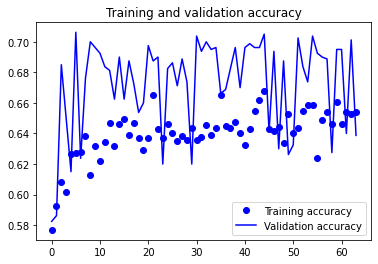

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

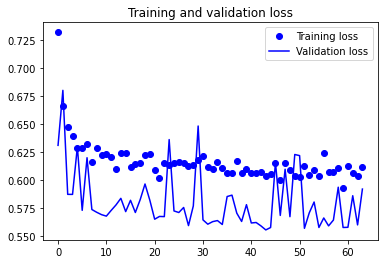

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_1x.append(test_accuracy)

16/16 [==============================] - 1s 59ms/step - loss: 0.6100 - acc: 0.6438

---------------------------------
Accuracy: 64.38 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.74      0.68      0.71       219
         1.0       0.48      0.55      0.51       117

    accuracy                           0.64       336
   macro avg       0.61      0.62      0.61       336
weighted avg       0.65      0.64      0.64       336



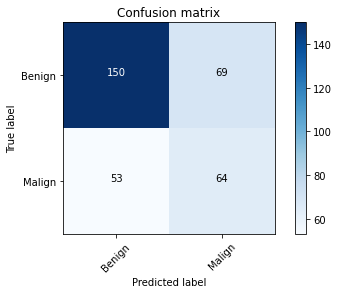

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

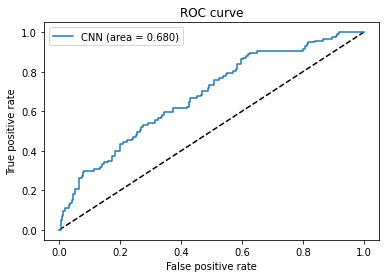

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_1x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  64
FP:  69
TN:  150
FN:  53

TPR(Recall): 		 0.547
FPR: 			 0.3151

Precision: 		 0.4812
TNR(Specificity): 	 0.6849


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

##3.2.1 1-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_1FT_DA_1x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last convolutional block 
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 13s 138ms/step - loss: 0.8901 - acc: 0.5769 - val_loss: 0.6093 - val_acc: 0.6413
Epoch 2/100
93/93 [==============================] - 13s 137ms/step - loss: 0.6541 - acc: 0.5965 -

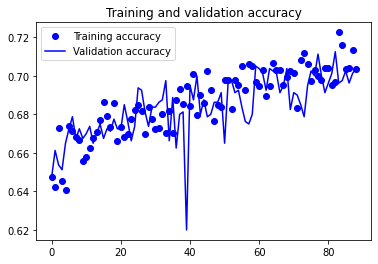

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

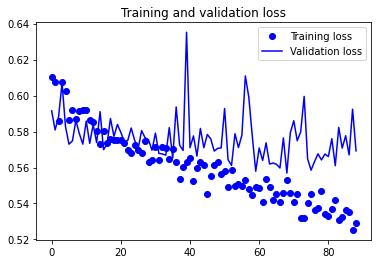

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_1x.append(test_accuracy)

16/16 [==============================] - 1s 61ms/step - loss: 0.6081 - acc: 0.6219

---------------------------------
Accuracy: 62.19 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.74      0.63      0.68       219
         1.0       0.46      0.58      0.51       117

    accuracy                           0.61       336
   macro avg       0.60      0.61      0.60       336
weighted avg       0.64      0.61      0.62       336



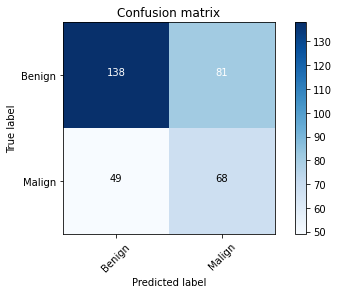

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

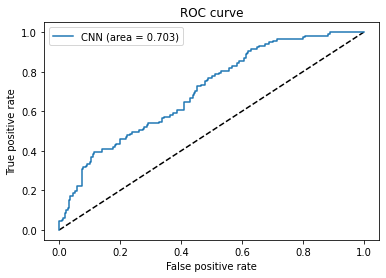

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_1x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  68
FP:  81
TN:  138
FN:  49

TPR(Recall): 		 0.5812
FPR: 			 0.3699

Precision: 		 0.4564
TNR(Specificity): 	 0.6301


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.3.1 2-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_2FT_1x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 13s 136ms/step - loss: 0.8021 - acc: 0.5726 - val_loss: 0.7245 - val_acc: 0.5888
Epoch 2/100
93/93 [==============================] - 13s 136ms/step - loss: 0.6350 - acc: 0.6374 -

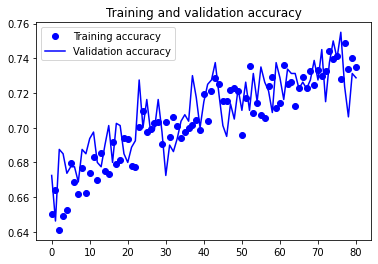

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

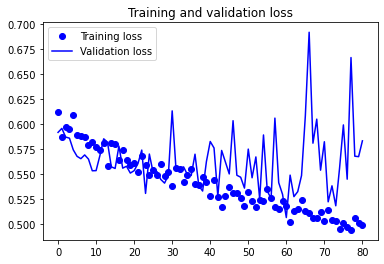

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_1x.append(test_accuracy)

16/16 [==============================] - 1s 59ms/step - loss: 0.5820 - acc: 0.7125

---------------------------------
Accuracy: 71.25 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.80      0.75      0.77       219
         1.0       0.58      0.64      0.61       117

    accuracy                           0.71       336
   macro avg       0.69      0.70      0.69       336
weighted avg       0.72      0.71      0.72       336



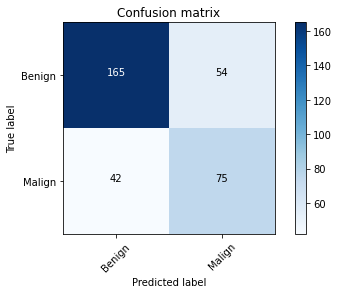

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

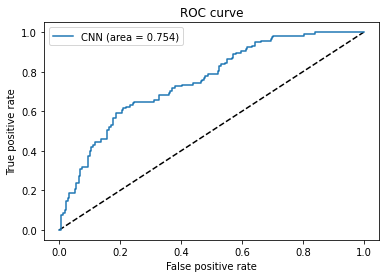

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_1x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  75
FP:  54
TN:  165
FN:  42

TPR(Recall): 		 0.641
FPR: 			 0.2466

Precision: 		 0.5814
TNR(Specificity): 	 0.7534


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.4.2 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_3FT_DA_1x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/100
93/93 [==============================] - 13s 137ms/step - loss: 0.8357 - acc: 0.6305 - val_loss: 0.7203 - val_acc: 0.5763
Epoch 2/100
93/93 [==============================] - 13s 136ms/step - loss: 0.6606 - acc: 0.6160 -

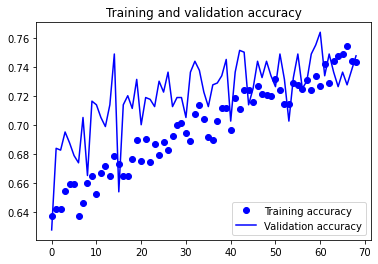

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

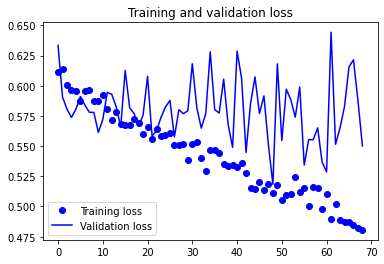

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_1x.append(test_accuracy)

16/16 [==============================] - 1s 60ms/step - loss: 0.5871 - acc: 0.7031

---------------------------------
Accuracy: 70.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.75      0.76       219
         1.0       0.56      0.60      0.58       117

    accuracy                           0.70       336
   macro avg       0.67      0.67      0.67       336
weighted avg       0.70      0.70      0.70       336



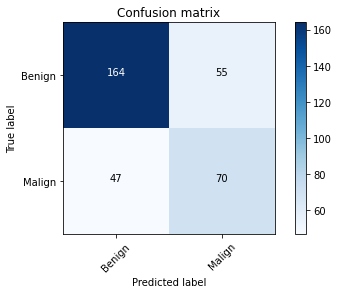

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

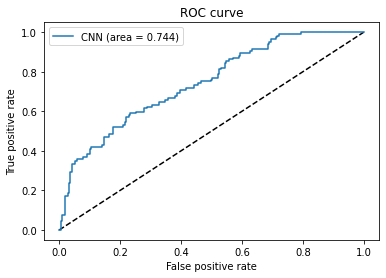

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_1x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  70
FP:  55
TN:  164
FN:  47

TPR(Recall): 		 0.5983
FPR: 			 0.2511

Precision: 		 0.56
TNR(Specificity): 	 0.7489


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.5.1 All-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_DA_1x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=30,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/30
93/93 [==============================] - 13s 136ms/step - loss: 0.9883 - acc: 0.5905 - val_loss: 0.6334 - val_acc: 0.6125
Epoch 2/30
93/93 [==============================] - 13s 137ms/step - loss: 0.6491 - acc: 0.5941 - v

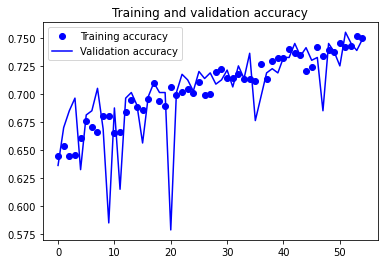

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

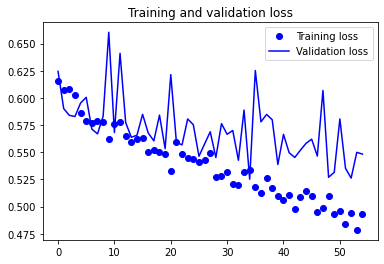

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_1x.append(test_accuracy)

16/16 [==============================] - 1s 60ms/step - loss: 0.5721 - acc: 0.6562

---------------------------------
Accuracy: 65.62 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.63      0.70       219
         1.0       0.49      0.67      0.57       117

    accuracy                           0.65       336
   macro avg       0.64      0.65      0.63       336
weighted avg       0.68      0.65      0.65       336



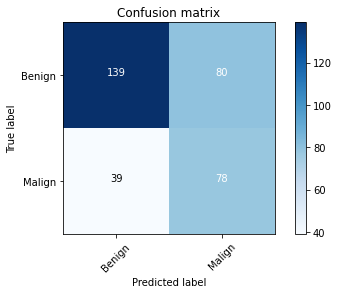

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

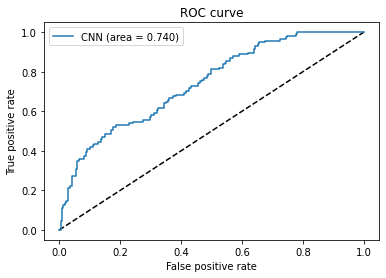

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_1x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  78
FP:  80
TN:  139
FN:  39

TPR(Recall): 		 0.6667
FPR: 			 0.3653

Precision: 		 0.4937
TNR(Specificity): 	 0.6347


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

# 4.VGG16: Flatten() + 3x [Dropout(0.5), Dense(256)]



In [ ]:
INPUT_SHAPE = (150, 150, 3)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

##3.1.1 0-Fine-Tuning Strategy With Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_0FT_DA_3x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Epoch 1/100
93/93 [==============================] - 19s 129ms/step - loss: 0.8173 - acc: 0.5435 - val_loss: 0.6750 - val_acc: 0.5763
Epoch 2/100
93/93 [==============================] - 12s 124ms/step - loss: 0.7043 - acc: 0.5608 - val_loss: 0.6764 - val_acc: 0.5763
Epoch 3/100
93/93 [==============================] - 11s 122ms/step - loss: 0.6764 - acc: 0.6024 - val_loss: 0.6777 - val_acc: 0.5763
Epoch 4/100
93/93 [==============================] - 11s 121ms/step - loss: 0.6869 - acc: 0.5951 - val_loss: 0.6630 - val_acc: 0.6700
Epoch 5/100
93/93 [==============================] - 12s 124ms/step - loss: 0.6785 - acc: 0.5730 - val_loss: 0.6453 - val_acc: 0.5763
Epoch 6/100
93/93 [==============================] - 11s 124ms/step - loss: 0.6735 - acc: 0.5819 - val_loss: 0.6443 - val_acc: 0.5763
Epoch 7/100
93/93 [==============================] - 12s 124ms/step - loss: 0.6560 - acc: 0.6024 - val_loss: 0.6370 - val_acc: 0.5763
Epoch 8/100
93/93 [==============================] - 12s 125ms

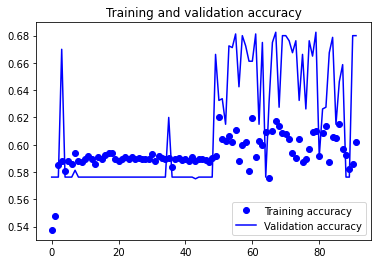

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

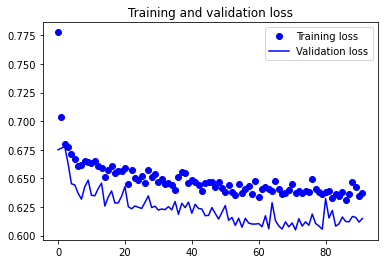

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 32ms/step - loss: 0.6144 - acc: 0.6719

---------------------------------
Accuracy: 67.19 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.70      0.84      0.77       219
         1.0       0.53      0.33      0.41       117

    accuracy                           0.66       336
   macro avg       0.61      0.59      0.59       336
weighted avg       0.64      0.66      0.64       336



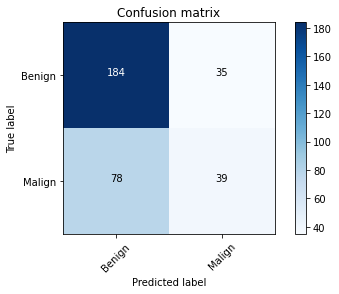

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

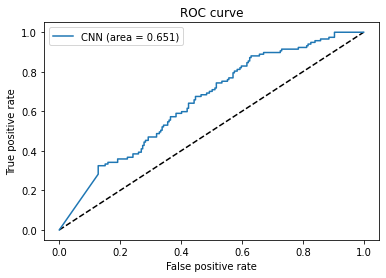

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  39
FP:  35
TN:  184
FN:  78

TPR(Recall): 		 0.3333
FPR: 			 0.1598

Precision: 		 0.527
TNR(Specificity): 	 0.8402


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

##3.2.1 1-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_1FT_DA_3x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last convolutional block 
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)              

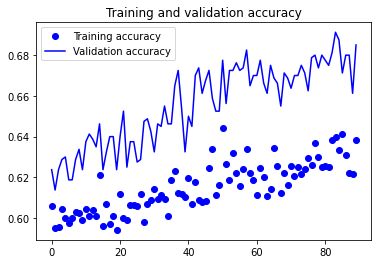

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

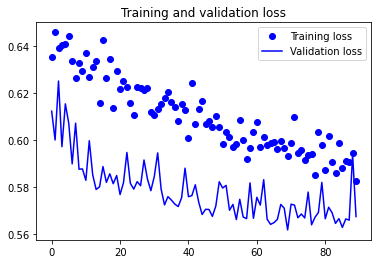

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 33ms/step - loss: 0.5947 - acc: 0.6344

---------------------------------
Accuracy: 63.44 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.72      0.68      0.70       219
         1.0       0.46      0.51      0.49       117

    accuracy                           0.62       336
   macro avg       0.59      0.60      0.59       336
weighted avg       0.63      0.62      0.63       336



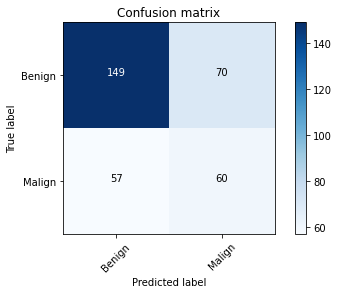

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

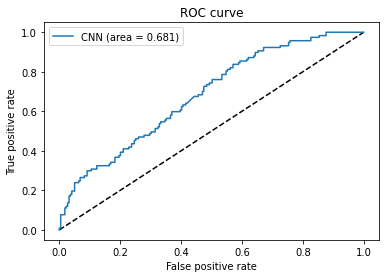

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  60
FP:  70
TN:  149
FN:  57

TPR(Recall): 		 0.5128
FPR: 			 0.3196

Precision: 		 0.4615
TNR(Specificity): 	 0.6804


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.3.1 2-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_2FT_3x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)              

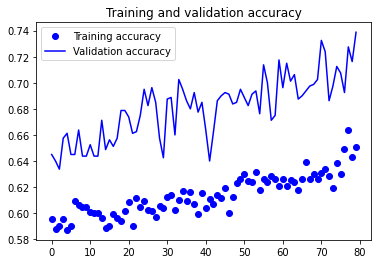

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

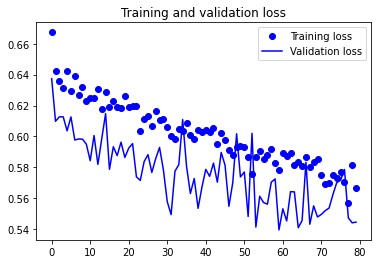

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 31ms/step - loss: 0.5877 - acc: 0.6781

---------------------------------
Accuracy: 67.81 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.73      0.77      0.75       219
         1.0       0.52      0.46      0.49       117

    accuracy                           0.66       336
   macro avg       0.62      0.62      0.62       336
weighted avg       0.66      0.66      0.66       336



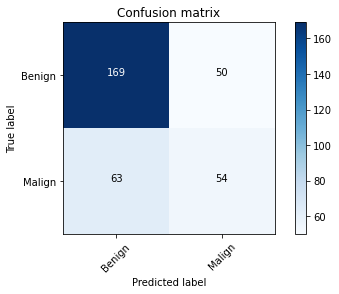

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

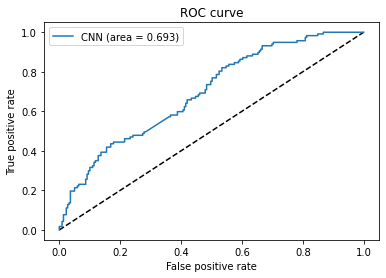

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  54
FP:  50
TN:  169
FN:  63

TPR(Recall): 		 0.4615
FPR: 			 0.2283

Precision: 		 0.5192
TNR(Specificity): 	 0.7717


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.4.2 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_3FT_DA')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)              

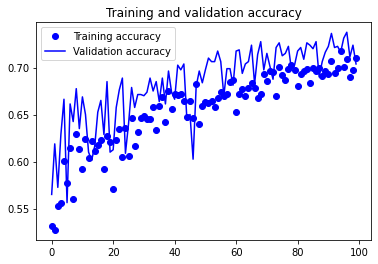

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

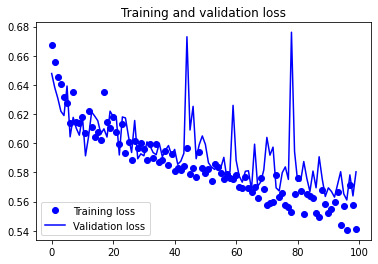

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 32ms/step - loss: 0.5809 - acc: 0.6562

---------------------------------
Accuracy: 65.62 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.64      0.69       219
         1.0       0.48      0.62      0.54       117

    accuracy                           0.63       336
   macro avg       0.62      0.63      0.62       336
weighted avg       0.66      0.63      0.64       336



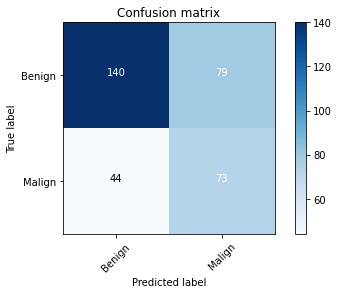

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

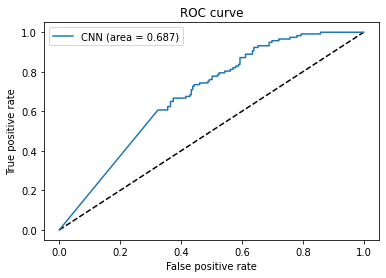

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  73
FP:  79
TN:  140
FN:  44

TPR(Recall): 		 0.6239
FPR: 			 0.3607

Precision: 		 0.4803
TNR(Specificity): 	 0.6393


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 4.5.1 All-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_DA_3x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

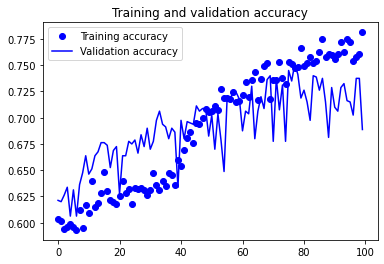

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

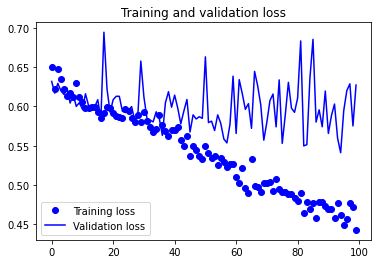

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_3x.append(test_accuracy)

16/16 [==============================] - 1s 32ms/step - loss: 0.5670 - acc: 0.7063

---------------------------------
Accuracy: 70.63 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.81      0.70      0.75       219
         1.0       0.55      0.68      0.61       117

    accuracy                           0.69       336
   macro avg       0.68      0.69      0.68       336
weighted avg       0.72      0.69      0.70       336



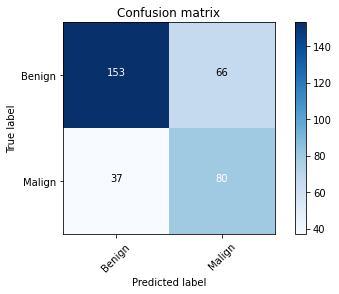

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

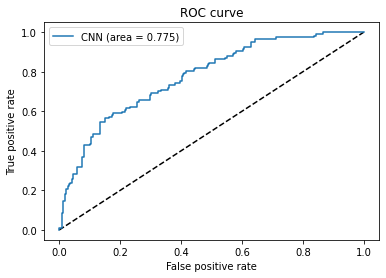

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_3x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  80
FP:  66
TN:  153
FN:  37

TPR(Recall): 		 0.6838
FPR: 			 0.3014

Precision: 		 0.5479
TNR(Specificity): 	 0.6986


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

# 5.VGG16: Flatten() + 5x [Dropout(0.5), Dense(256)]



##3.1.1 0-Fine-Tuning Strategy With Data Augmentation

In [ ]:
INPUT_SHAPE = (150, 150, 1)
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 20
EPOCHS = 200

In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='precision'),
      #metrics.Recall(name='recall'),
      #metrics.AUC(name='auc'),
      # metrics.TruePositives(name='tp'),
      # metrics.FalsePositives(name='fp'),
      # metrics.TrueNegatives(name='tn'),
      # metrics.FalseNegatives(name='fn'),     
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_loss', patience=20, verbose=0,
     mode='auto', restore_best_weights=True
)

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_0FT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

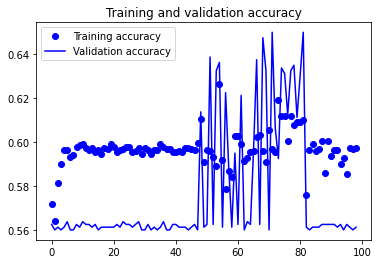

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

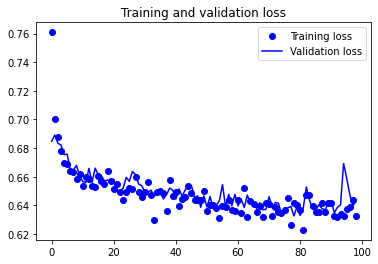

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 56ms/step - loss: 0.6234 - acc: 0.6406

---------------------------------
Accuracy: 64.06 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.70      0.76      0.73       219
         1.0       0.46      0.38      0.42       117

    accuracy                           0.63       336
   macro avg       0.58      0.57      0.57       336
weighted avg       0.62      0.63      0.62       336



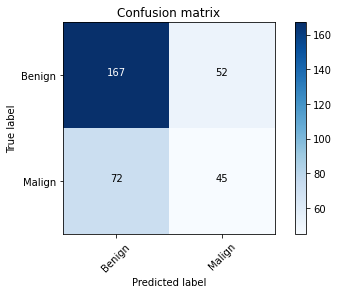

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

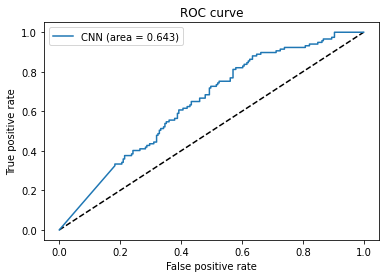

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  45
FP:  52
TN:  167
FN:  72

TPR(Recall): 		 0.3846
FPR: 			 0.2374

Precision: 		 0.4639
TNR(Specificity): 	 0.7626


In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

##3.2.1 1-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_1FT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last convolutional block 
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block5_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

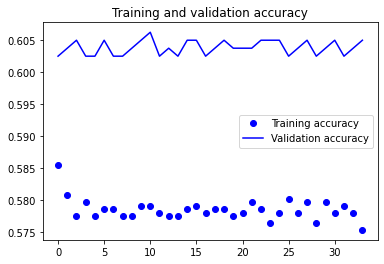

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

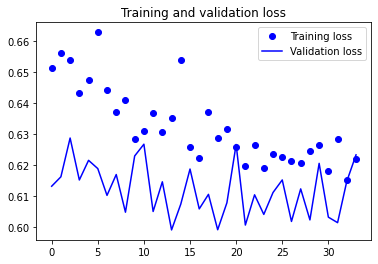

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 49ms/step - loss: 0.6061 - acc: 0.6531

---------------------------------
Accuracy: 65.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       219
         1.0       0.00      0.00      0.00       117

    accuracy                           0.65       336
   macro avg       0.33      0.50      0.39       336
weighted avg       0.42      0.65      0.51       336



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


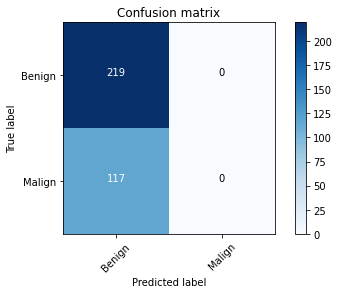

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

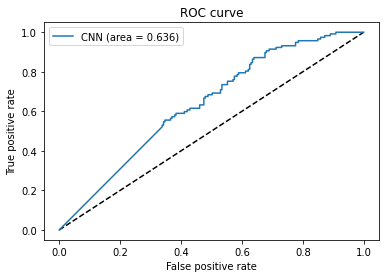

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.3.1 2-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_2FT_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 2 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block4_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)              

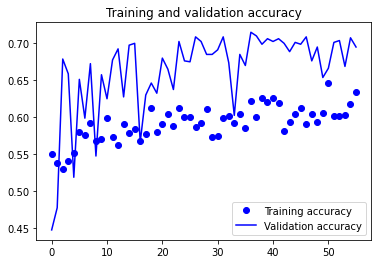

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

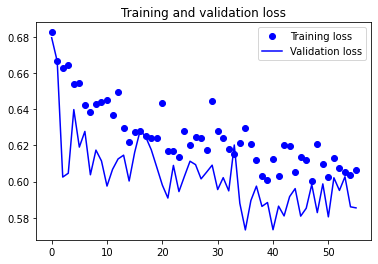

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 48ms/step - loss: 0.5990 - acc: 0.6719

---------------------------------
Accuracy: 67.19 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75       219
         1.0       0.51      0.41      0.45       117

    accuracy                           0.66       336
   macro avg       0.61      0.60      0.60       336
weighted avg       0.64      0.66      0.65       336



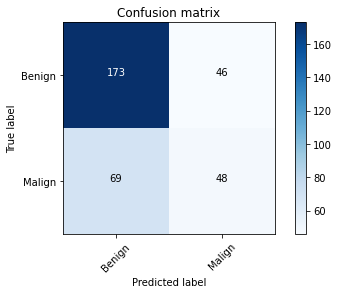

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

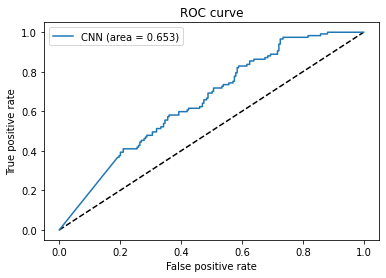

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 3.4.2 3-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_3FT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze last 3 convolutional blocks
conv_base.trainable = True
set_trainable = False 
for layer in conv_base.layers:
  if layer.name == "block3_conv1":
    set_trainable = True
  if set_trainable:
    layer.trainable = True 
  else: 
    layer.trainable = False 

model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)              

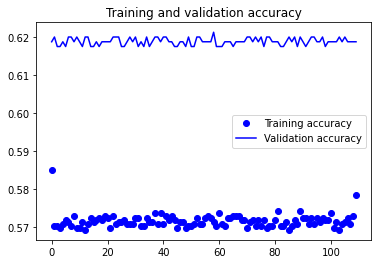

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

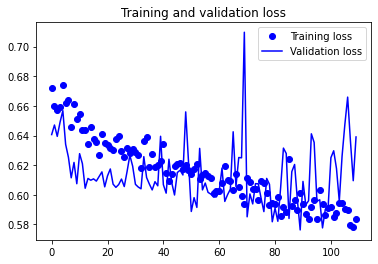

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 48ms/step - loss: 0.5957 - acc: 0.6531

---------------------------------
Accuracy: 65.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       219
         1.0       0.00      0.00      0.00       117

    accuracy                           0.65       336
   macro avg       0.33      0.50      0.39       336
weighted avg       0.42      0.65      0.51       336



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


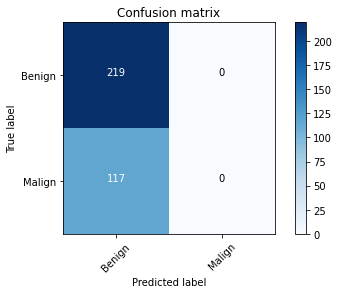

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

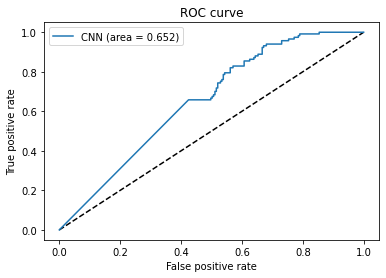

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

## 5.5.1 All-Fine-Tuning Strategy With Data Augmentation

In [ ]:
from keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers

#load VGG16 as convolutional base
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split, train_datagen, valid_datagen, test_datagen = init_data(base_NN="VGG16", GCN=False, augmentation=True)

#expand test images from grayscale to RGB 
if test_images.shape[3] == 1:
  test_images = np.repeat(test_images, 3, axis = 3)

print()
print(train_images_split.shape)
print(test_images.shape)

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done

(1873, 150, 150, 3)
(336, 150, 150, 3)


In [ ]:
checkpoint_filepath =  os.path.join(base_path, 'models/PreTrained-Benign-Malign/best_VGG16_ALLFT_DA_5x')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

#add custom fully-connected network on top of the already-trained base network 
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
#model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

#freeze convolutional base 
conv_base.trainable = False
model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-3), # lr = 0.0001
            metrics=METRICS) 

#train fully-connected added part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

#unfreeze all convolutional blocks
for layer in model.layers:
    layer.trainable = True 


model.summary()

model.compile(loss="binary_crossentropy",
            optimizer=optimizers.Adam(lr=1e-5), # lr = 0.00001
            metrics=METRICS)   

#jointly train both the unfreezed layers and the fully-connected part 
history = model.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=True),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback, GarbageCollectorCallback()])

model.load_weights(checkpoint_filepath)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 8192)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 256)               2097408   
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)              

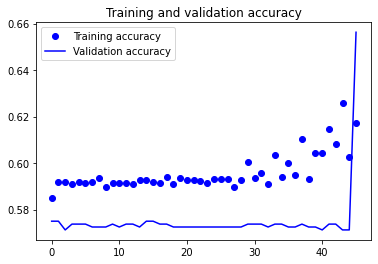

In [ ]:
plt_a = plot_acc(history)
#save & show plot
#plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

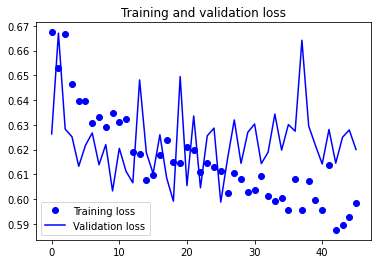

In [ ]:
plt_b = plot_loss(history)
#save & show plot
#plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_accuracy = model.evaluate(test_datagen.flow(test_images,
                                                            test_labels,
                                                            batch_size=BATCH_SIZE,
                                                            shuffle=False),
                                            steps=len(test_images) // BATCH_SIZE,
                                            callbacks=[GarbageCollectorCallback()]
)

print("\n---------------------------------")
print("Accuracy:", "%0.2f" % (test_accuracy*100), "%")
#print("Precision:", "%0.2f" % (test_precision*100), "%")
#print("Recall:", "%0.2f" % (test_recall*100), "%")
#print("AUC:", "%0.2f" % test_auc)
print("---------------------------------\n")
ACC_values_5x.append(test_accuracy)

16/16 [==============================] - 1s 49ms/step - loss: 0.6082 - acc: 0.6531

---------------------------------
Accuracy: 65.31 %
---------------------------------



Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.65      1.00      0.79       219
         1.0       0.00      0.00      0.00       117

    accuracy                           0.65       336
   macro avg       0.33      0.50      0.39       336
weighted avg       0.42      0.65      0.51       336



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


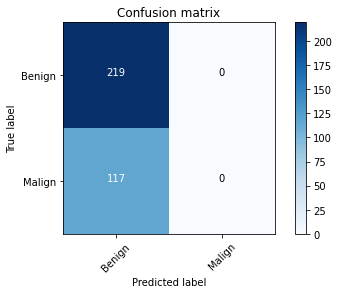

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
plt_0 = plot_confusion_matrix(model,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

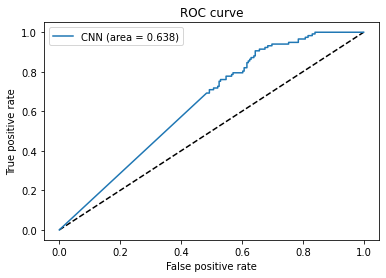

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model, test_images, test_labels)
AUC_values_5x.append(auc_1)

#save & show plot
#plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)

In [ ]:
#free RAM 
del model
del conv_base
del train_images_split 
del valid_images_split 
del train_labels_split 
del valid_labels_split

# Model Results Report

ACCURACY

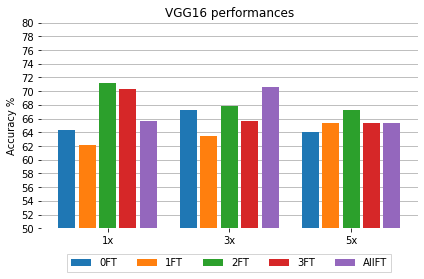

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['1x', '3x', '5x']
zero_ft = [64.38, 67.19, 64.06]
one_ft = [62.19, 63.44, 65.31]
two_ft = [71.25, 67.81, 67.19]
three_ft = [70.31, 65.62, 65.31]
all_ft = [65.62, 70.63, 65.31]

x = 3*np.arange(len(labels))  # the label locations
width = 0.42  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - 2*1.2*width, zero_ft, width, label='0FT')
rects2 = ax.bar(x - 1.2*width, one_ft, width, label='1FT')
rects3 = ax.bar(x, two_ft, width, label='2FT')
rects4 = ax.bar(x + 1.2*width, three_ft, width, label='3FT')
rects5 = ax.bar(x + 2*1.2*width, all_ft, width, label='AllFT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Accuracy %')
ax.set_title('VGG16 performances')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([50,80])
ax.set_yticks(np.arange(50,82,2))

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_axisbelow(True)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)
#autolabel(rects5)

fig.tight_layout()
plt.grid(axis='y')
plt.show()

AUC

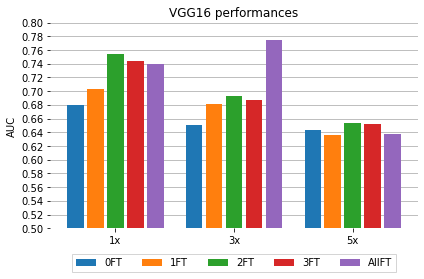

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['1x', '3x', '5x']
zero_ft = [0.680, 0.651, 0.643]
one_ft = [0.703, 0.681, 0.636]
two_ft = [0.754, 0.693, 0.653]
three_ft = [0.744, 0.687, 0.652]
all_ft = [0.740, 0.775, 0.638]

x = 3*np.arange(len(labels))  # the label locations
width = 0.42  # the width of the bars

fig, ax = plt.subplots()

rects1 = ax.bar(x - 2*1.2*width, zero_ft, width, label='0FT')
rects2 = ax.bar(x - 1.2*width, one_ft, width, label='1FT')
rects3 = ax.bar(x, two_ft, width, label='2FT')
rects4 = ax.bar(x + 1.2*width, three_ft, width, label='3FT')
rects5 = ax.bar(x + 2*1.2*width, all_ft, width, label='AllFT')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('AUC')
ax.set_title('VGG16 performances')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0.5,0.8])
ax.set_yticks(np.arange(0.5,0.8,0.02))

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=False, shadow=False, ncol=5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_axisbelow(True)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

#autolabel(rects1)
#autolabel(rects2)
#autolabel(rects3)
#autolabel(rects4)
#autolabel(rects5)

fig.tight_layout()
plt.grid(axis='y')
plt.show()